# How much of the variation in the hosptials thrombolysis rate can be attributed to the difference in the hospital processes, and to different patient populations?

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

The SHAP values for each feature are comprised of the feature’s main effect (what is due to the feature value, the standalone effect) and all of the pairwise interaction effects with each of the other features (a value per feature pairings).

In this notebook we will use the single model fitted to all of the data, no test set (from notebook 03a) and focus on understanding the amount of variance in hospital IVT that is captured in feature SHAP values (from notebook 03a) and SHAP main effects (from notebook 03c) using linear regressions and multiple linear regressions.

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we read in an already fitted XGBoost model to the SAMueL dataset (and the SHAP values), to predict whether a patient recieves thrombolysis from the values of 10 features, using all data to train (no test set). We explore the relationship between SHAP values and SHAP main effect and the hospital IVT rate.

We find that thrombolysis rate may be well predicted from just the average main effect SHAP values for each feature at each hospital. Hospital ID and hopsital processes (arrival-to-scan time) explain the majority (at least two thirds) of the between-hospital variation in thrombolysis use. Patient characteristics at each hopsital explain about one third of the variation in thrombolysis use.

## Model and data

Using the XGBoost model trained on all of the data (no test set used) from notebook 03a_xgb_combined_shap_key_features.ipynb. The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

## Aims
* Using XGBoost model fitted on all the data (no test set) using 10 features
* Using SHAP values previously calculated
* Understand the amount of variance in hospital IVT that is captured in feature SHAP values and SHAP main effects (using regressions and multiple regressions)
* Divide the features into two groups: patient features and hosptial features

## Observations

Mean SHAP values, including interactions, for patients attending each hopsital explain 93% of between-hospital variation in thrombolysis rate. The mean main effect SHAP values at each hopsital explain 94% of between-hospital variation in thrombolysis rate.

Stroke team ID and processes (arrival-to scan time) explained 75% of the between-hopsital variation in thrombolysis. Combining patient characteristics explained 34% of the between-hopsital variation in thrombolysis.

It is perhaps a little suprising that thrombolysis rate may be so welll predicted just from average SHAP feature values at each hopsital.

When examining average feature SHAP effects (main effect only) for each team, the three features that most explain variation in thrombolysis rates were mean SHAP values for:

* Stroke team (r-squared = 0.56)
* Arrival-to-scan time (r-squared = 0.24)
* Stroke severity  (r-squared = 0.12)

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap

from scipy import stats
from sklearn import linear_model

import os
import pickle

# .floor and .ceil
import math 

# So can take deep copy
import copy

from os.path import exists
import json

## Set filenames

In [2]:
# Set up strings (describing the model) to use in filenames
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03e'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

The model used in this notebook is fitted using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Get list of feature names

In [7]:
feature_names = list(test_data_kfold[0])

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [8]:
X_data = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [9]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


### One-hot encode hospital feature

In [10]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X_data.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X_data['Stroke team'], prefix = 'team')
X_data = pd.concat([X_data, X_hosp], axis=1)
X_data.drop('Stroke team', axis=1, inplace=True)

In [11]:
# get feature names
feature_names_ohe = list(X_data)

## XGBoost model
An XGBoost model was trained on the full dataset (rather than train/test splits used to assess accuracy) in notebook 03a. These models are saved f'./saved_models/03a_{model_text}.p'.

## Get SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

'Raw' SHAP values from XGBoost model are log odds ratios.

In notebook 03a we used the TreeExplainer from the shap library (https://shap.readthedocs.io/en/latest/index.html) to calculate the SHAP values. This is a fast and exact method to estimate SHAP values for tree models and ensembles of tree.

Load SHAP values from pickle (calculated in notebook 03a).

In [12]:
filename = f'./output/03a_{model_text}_shap_values_extended.p'

with open(filename, 'rb') as filehandler:
    shap_values_extended = pickle.load(filehandler)

The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [13]:
shap_values_extended[0]

.values =
array([ 7.56502628e-01,  4.88319576e-01,  1.10273695e+00,  4.40223962e-01,
        4.98975307e-01,  2.02812225e-01, -2.62601525e-01,  3.69181409e-02,
        2.30234995e-01,  3.20923195e-04, -6.03703642e-03, -7.17267860e-04,
        0.00000000e+00, -4.91688668e-04,  1.20360847e-03,  1.77788886e-03,
       -4.34198463e-03, -2.76021136e-04, -2.79896380e-03,  3.52182891e-03,
       -2.73969141e-04,  8.53505917e-03, -5.28220041e-03, -8.25227005e-04,
        6.20208494e-03,  6.92215608e-03, -6.32244349e-03, -3.35367222e-04,
        7.81939551e-03, -4.71850217e-06, -4.25534381e-05,  6.48253039e-03,
        8.43156071e-04, -6.28353562e-04, -1.25156669e-02, -7.92063680e-03,
       -1.99409085e-03, -5.05548809e-03, -3.90118686e-03,  1.30317558e-03,
        0.00000000e+00, -6.48246554e-04,  1.19629130e-03,  8.26304778e-04,
        1.28053436e-02,  2.55714403e-03, -3.20375757e-03,  4.23251512e-03,
       -7.19791185e-03,  4.02670400e-03,  3.75146419e-03,  8.31848301e-04,
        3.45067

### How does the SHAP value for patient features compare to the thrombolysis rate of the hospital?

Create dataframe containing the hospital's IVT rate and mean SHAP value for each feature (for those patients that attend the hospital).

In [14]:
# Get SHAP values
shap_values = shap_values_extended.values

# Get list of unique stroke team names
unique_stroketeams_list = list(set(data["Stroke team"]))

In [15]:
# Calculate IVT rate per hosptial
df_hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]
df_hosp_ivt_rate

Stroke team
AGNOF1041H    0.352468
AKCGO9726K    0.369748
AOBTM3098N    0.218803
APXEE8191H    0.226481
ATDID5461S    0.240385
                ...   
YPKYH1768F    0.246057
YQMZV4284N    0.236170
ZBVSO0975W    0.250000
ZHCLE1578P    0.223639
ZRRCV7012C    0.157670
Name: Thrombolysis, Length: 132, dtype: float64

In [16]:
# Create dataframe with hospital as index, column per feature, containing
# mean SHAP value for feature for patients that attend that hospital

# Initialise list
mean_values_hosp = []

for h in unique_stroketeams_list:
#    calculate mean SHAP for the patients that attend hospital
    mask = data["Stroke team"] == h
    mean_values_hosp.append(np.mean(shap_values[mask],axis=0))

df_mean_shap_values_per_hosp = pd.DataFrame(data=mean_values_hosp, 
                                            index=unique_stroketeams_list,
                                            columns=feature_names_ohe)

In [17]:
df_mean_shap_values_per_hosp.head(10)

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_XKAWN3771U,team_XPABC1435F,team_XQAGA4299B,team_XWUBX0795L,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C
AOBTM3098N,-0.706683,-0.827253,-0.164386,0.023894,0.008445,-0.062407,-0.079294,-0.094993,-0.040437,0.001599,...,-0.008356,0.003196,0.002574,-0.002853,0.000365,0.000367,-0.001572,0.002756,-0.001949,0.003640
QQUVD2066Z,0.136372,-0.980927,-0.131322,0.193710,-0.059096,-0.078017,-0.043302,0.027973,-0.029430,0.001890,...,-0.006836,0.002609,0.003206,-0.004560,0.000569,0.000358,-0.001619,0.002432,-0.002055,0.002883
JHDQL1362V,-0.402815,-1.126089,-0.295140,0.032842,-0.039683,-0.010591,-0.094071,-0.054438,-0.011553,0.002150,...,-0.007632,0.002562,0.003296,-0.004491,0.000480,0.000294,-0.001585,0.002335,-0.001919,0.002991
BXXZS5063A,-0.630360,-0.652467,-0.130985,-0.327233,0.161356,-0.135734,-0.036724,0.009042,-0.018232,-0.000024,...,-0.010076,0.003345,0.003047,-0.002476,0.000285,0.000417,-0.001705,0.002453,-0.001873,0.003620
IUMNL9626U,-1.191899,-0.707900,-0.556744,0.202532,-0.077063,-0.044510,-0.186686,0.028765,-0.011223,0.001455,...,-0.007012,0.003013,0.003101,-0.003294,0.000428,0.000353,-0.001492,0.002573,-0.002082,0.002913
PAYNN3649Z,-0.200419,-1.407759,-0.190069,-0.042549,-0.072930,-0.030307,-0.101289,-0.002426,-0.024898,0.001213,...,-0.007339,0.002914,0.003123,-0.003681,0.000472,0.000399,-0.001778,0.002519,-0.002033,0.003257
HONZP0443O,-0.115365,-1.775631,-0.104938,-0.091275,-0.140787,-0.074620,-0.048155,-0.045987,-0.009660,0.001759,...,-0.008071,0.002626,0.002954,-0.004755,0.000428,0.000342,-0.001757,0.002184,-0.002297,0.003339
NZECY6641V,-0.605714,-1.111112,-0.105084,-0.021646,0.061730,-0.105097,-0.076584,-0.061997,-0.004997,0.000793,...,-0.008988,0.003355,0.002555,-0.002640,0.000349,0.000422,-0.001669,0.002710,-0.002102,0.003704
AGNOF1041H,0.126956,-1.027696,-0.168953,0.049088,0.038974,-0.056876,-0.039101,-0.019409,0.003548,-0.026516,...,-0.007271,0.001575,0.002990,-0.006388,0.000473,0.000147,-0.001514,0.002490,-0.001605,0.002535
XQAGA4299B,-0.483651,-0.920830,-0.268562,-0.084444,-0.028964,-0.091729,-0.080115,-0.039649,-0.069931,0.001583,...,-0.007951,0.002682,-0.508688,-0.003387,0.000409,0.000374,-0.001626,0.002407,-0.002044,0.003146


In [18]:
# Add IVT rate to dataframe
df_mean_shap_values_per_hosp = df_mean_shap_values_per_hosp.join(df_hosp_ivt_rate)

In [19]:
df_mean_shap_values_per_hosp.head(10)

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_XPABC1435F,team_XQAGA4299B,team_XWUBX0795L,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C,Thrombolysis
AOBTM3098N,-0.706683,-0.827253,-0.164386,0.023894,0.008445,-0.062407,-0.079294,-0.094993,-0.040437,0.001599,...,0.003196,0.002574,-0.002853,0.000365,0.000367,-0.001572,0.002756,-0.001949,0.003640,0.218803
QQUVD2066Z,0.136372,-0.980927,-0.131322,0.193710,-0.059096,-0.078017,-0.043302,0.027973,-0.029430,0.001890,...,0.002609,0.003206,-0.004560,0.000569,0.000358,-0.001619,0.002432,-0.002055,0.002883,0.456376
JHDQL1362V,-0.402815,-1.126089,-0.295140,0.032842,-0.039683,-0.010591,-0.094071,-0.054438,-0.011553,0.002150,...,0.002562,0.003296,-0.004491,0.000480,0.000294,-0.001585,0.002335,-0.001919,0.002991,0.292797
BXXZS5063A,-0.630360,-0.652467,-0.130985,-0.327233,0.161356,-0.135734,-0.036724,0.009042,-0.018232,-0.000024,...,0.003345,0.003047,-0.002476,0.000285,0.000417,-0.001705,0.002453,-0.001873,0.003620,0.248529
IUMNL9626U,-1.191899,-0.707900,-0.556744,0.202532,-0.077063,-0.044510,-0.186686,0.028765,-0.011223,0.001455,...,0.003013,0.003101,-0.003294,0.000428,0.000353,-0.001492,0.002573,-0.002082,0.002913,0.185751
PAYNN3649Z,-0.200419,-1.407759,-0.190069,-0.042549,-0.072930,-0.030307,-0.101289,-0.002426,-0.024898,0.001213,...,0.002914,0.003123,-0.003681,0.000472,0.000399,-0.001778,0.002519,-0.002033,0.003257,0.277852
HONZP0443O,-0.115365,-1.775631,-0.104938,-0.091275,-0.140787,-0.074620,-0.048155,-0.045987,-0.009660,0.001759,...,0.002626,0.002954,-0.004755,0.000428,0.000342,-0.001757,0.002184,-0.002297,0.003339,0.264286
NZECY6641V,-0.605714,-1.111112,-0.105084,-0.021646,0.061730,-0.105097,-0.076584,-0.061997,-0.004997,0.000793,...,0.003355,0.002555,-0.002640,0.000349,0.000422,-0.001669,0.002710,-0.002102,0.003704,0.245763
AGNOF1041H,0.126956,-1.027696,-0.168953,0.049088,0.038974,-0.056876,-0.039101,-0.019409,0.003548,-0.026516,...,0.001575,0.002990,-0.006388,0.000473,0.000147,-0.001514,0.002490,-0.001605,0.002535,0.352468
XQAGA4299B,-0.483651,-0.920830,-0.268562,-0.084444,-0.028964,-0.091729,-0.080115,-0.039649,-0.069931,0.001583,...,0.002682,-0.508688,-0.003387,0.000409,0.000374,-0.001626,0.002407,-0.002044,0.003146,0.218579


Add in the mean SHAP value for the hospital feature (already calculated in notebook 03c)

In [20]:
filename = (f'./output/03d_{model_text}'
            f'_hospital_shap_vs_ivt_rate.csv')
df_hosp_shap = pd.read_csv(filename)
df_hosp_shap = df_hosp_shap.set_index("hospital")

In [21]:
df_mean_shap_values_per_hosp = df_mean_shap_values_per_hosp.join(df_hosp_shap, 
                                                                 rsuffix="_h")
df_mean_shap_values_per_hosp

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C,Thrombolysis,shap_mean_sv,Thrombolysis_h,shap_mean_me
AOBTM3098N,-0.706683,-0.827253,-0.164386,0.023894,0.008445,-0.062407,-0.079294,-0.094993,-0.040437,0.001599,...,0.000365,0.000367,-0.001572,0.002756,-0.001949,0.003640,0.218803,-0.401549,0.218803,-0.390772
QQUVD2066Z,0.136372,-0.980927,-0.131322,0.193710,-0.059096,-0.078017,-0.043302,0.027973,-0.029430,0.001890,...,0.000569,0.000358,-0.001619,0.002432,-0.002055,0.002883,0.456376,0.629639,0.456376,0.625144
JHDQL1362V,-0.402815,-1.126089,-0.295140,0.032842,-0.039683,-0.010591,-0.094071,-0.054438,-0.011553,0.002150,...,0.000480,0.000294,-0.001585,0.002335,-0.001919,0.002991,0.292797,0.010272,0.292797,0.040766
BXXZS5063A,-0.630360,-0.652467,-0.130985,-0.327233,0.161356,-0.135734,-0.036724,0.009042,-0.018232,-0.000024,...,0.000285,0.000417,-0.001705,0.002453,-0.001873,0.003620,0.248529,0.020597,0.248529,-0.039883
IUMNL9626U,-1.191899,-0.707900,-0.556744,0.202532,-0.077063,-0.044510,-0.186686,0.028765,-0.011223,0.001455,...,0.000428,0.000353,-0.001492,0.002573,-0.002082,0.002913,0.185751,-0.847366,0.185751,-0.814281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSFVN0229E,-1.055860,-0.471481,-0.355870,-0.107223,-0.016413,0.001053,-0.049371,-0.007234,-0.046051,0.000914,...,0.000322,0.000387,-0.001667,0.002300,-0.002183,0.003451,0.252941,0.109983,0.252941,0.119907
PSNKC7508G,-0.524928,-1.070266,-0.061160,0.066380,-0.051209,-0.073205,-0.028887,-0.014873,-0.016516,0.001007,...,0.000392,0.000421,-0.001802,0.002870,-0.002280,0.003722,0.319038,-0.004237,0.319038,0.000200
EQPWM6065O,-0.607676,-1.112876,-0.114227,-0.165922,-0.069612,-0.056396,-0.046210,-0.169364,-0.003832,0.000949,...,0.000350,0.000439,-0.001336,0.002453,-0.002153,0.003819,0.313088,0.483091,0.313088,0.552636
TXYJJ1019H,-0.336146,-0.928714,-0.225783,-0.106874,-0.098462,-0.033309,-0.065516,0.016631,-0.030836,0.001079,...,0.000412,0.000452,-0.001669,0.002441,-0.002105,0.003442,0.275946,0.057981,0.275946,0.084655


### Fit regressions to processed data

We will fit

* a linear regression for all the features against a target feature (thrombolysis rate).
* using multiple linear regression to predict the hospitals thrombolysis rate from a subset of features.

Define a function to fit and plot a linear regression between hospital thrombolysis rate and the SHAP value for a list of features (mean for those instances that attend the hospital)

In [22]:
def plot_regressions(df_hosp_mean, features, x_label_text):
    """
    Fit and plot a linear regression for all the features in the features list
    against the target feature (Thrombolysis rate).
    
    df_hosp_mean [pandas DataFrame]: column per feature, row per hospital, value
                              is mean for instances that attend that hospital
    features [list]: Features to individually fit a linear regression against 
                     the hospital thrombolysis rate
    x_label_text [str]: Text to use in first part of x axis label string
    Return []: empty
    """
    
    n_features = len(features)
    cols = 3
    rows = np.int((n_features / cols) + 1)
    count = 1

    fig = plt.figure(figsize=((6*cols),(6*rows)))
    
    for feat in features: 
        # Setup data for chart
        x = df_hosp_mean[feat]
        y = df_hosp_mean['Thrombolysis']

        # Fit a regression line to the x2 points
        slope, intercept, r_value, p_value, std_err = \
            stats.linregress(x, y)
        r_square = r_value ** 2
        y_pred = intercept + (x * slope)

        # Create scatter plot with regression line
        ax = fig.add_subplot(rows,cols,count)

        ax.scatter(x, y, color = 'k', marker="o", s=20)
        ax.plot (x, y_pred, color = 'k', linestyle='--', linewidth=1)

        ax.set_xlabel(f"{x_label_text} {feat} "
                      f"\n(mean of the instances that attend the hospital)")
        ax.set_ylabel('Thrombolysis rate')

        (xmin, xmax) = ax.get_xlim()
        (ymin, ymax) = ax.get_ylim()

        plt.grid()

        # Add  text
        f = (str("{:.2f}".format(slope)) + 'x + ' + 
              str("{:.2f}".format(intercept)))
        text = (f'R squared: {r_square:.3f}\np: '
                 f'{p_value:0.4f}\nformula: {f}')

    
        x_placement = xmin + 0.05*(xmax - xmin)
        y_placement = ymax - 0.15*(ymax - ymin)
        ax.text(x_placement, y_placement, text,
                 bbox=dict(facecolor='white', edgecolor='white'))

        count+=1
        
    plt.show()
    
    return()

Define a function to fit and plot a multiple regression on a set of features vs hostpial thrombolysis rate

In [23]:
def fit_and_plot_multiple_regression(df_hosp_mean, features, x_label_text="", 
                                     ax=None):
    """
    df_hosp_mean contains the data, features contain the columns to plot as a 
    multiple regression against the thrombolysis rate.
    
    df_hosp_mean [DataFrame]:column per feature, row per hospital, value is 
                             mean for instances that attend that hospital
    features [list]: list of feature names (column titles in df_hosp_mean) to 
                     include in the multiple regression
    x_label_text [str]: Text to use in x axis label
    ax [matplotlib ax object]: matplotlib ax object
    return [matplotlib ax object]
    """

    X = df_hosp_mean[features]
    y = df_hosp_mean['Thrombolysis']

    regr = linear_model.LinearRegression()
    regr.fit(X, y)

    df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features, 
                                columns=["coeff"])
    print(df_reg_coeff)
    print()
    
    # performance
    y_pred = regr.predict(X)

    # Fit a regression line to the obs and pred IVT use
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(y, y_pred)
    r_square = r_value ** 2
    y_pred_line = intercept + (y * slope)
    
    # Create scatter plot with regression line
    if ax is None: 
        ax = plt.gca()

    ax.scatter(y_pred, y, color = 'k', marker="o", s=20)
    ax.plot (y_pred_line, y, color = 'k', linestyle='--', linewidth=1)

    (xmin, xmax) = ax.get_xlim()
    (ymin, ymax) = ax.get_ylim()
    axis_min = min(xmin, ymin)
    axis_max = max(xmax, ymax)
    
    ax.set_xlim(axis_min, axis_max)
    ax.set_ylim(axis_min, axis_max)

    ax.set_xlabel(f'Hospital thrombolysis rate (predicted{x_label_text})')
    ax.set_ylabel('Hospital thrombolysis rate (observed)')

    plt.grid()

    # Add  text
    f = (str("{:.2f}".format(slope)) + 'x + ' + 
          str("{:.2f}".format(intercept)))
    text = (f'R squared: {r_square:.3f}\np: '
             f'{p_value:0.4f}\nformula: {f}')
    
    x_placement = axis_min + 0.05*(axis_max - axis_min)
    y_placement = axis_max - 0.15*(axis_max - axis_min)
    ax.text(x_placement, y_placement, text,
             bbox=dict(facecolor='white', edgecolor='white'))
    
    return(ax)

#### Linear regression of each feature vs. hosptial thrombolysis rate

Regression between hosptial IVT rate and SHAP value for features (mean for those instances that attend the hospital)



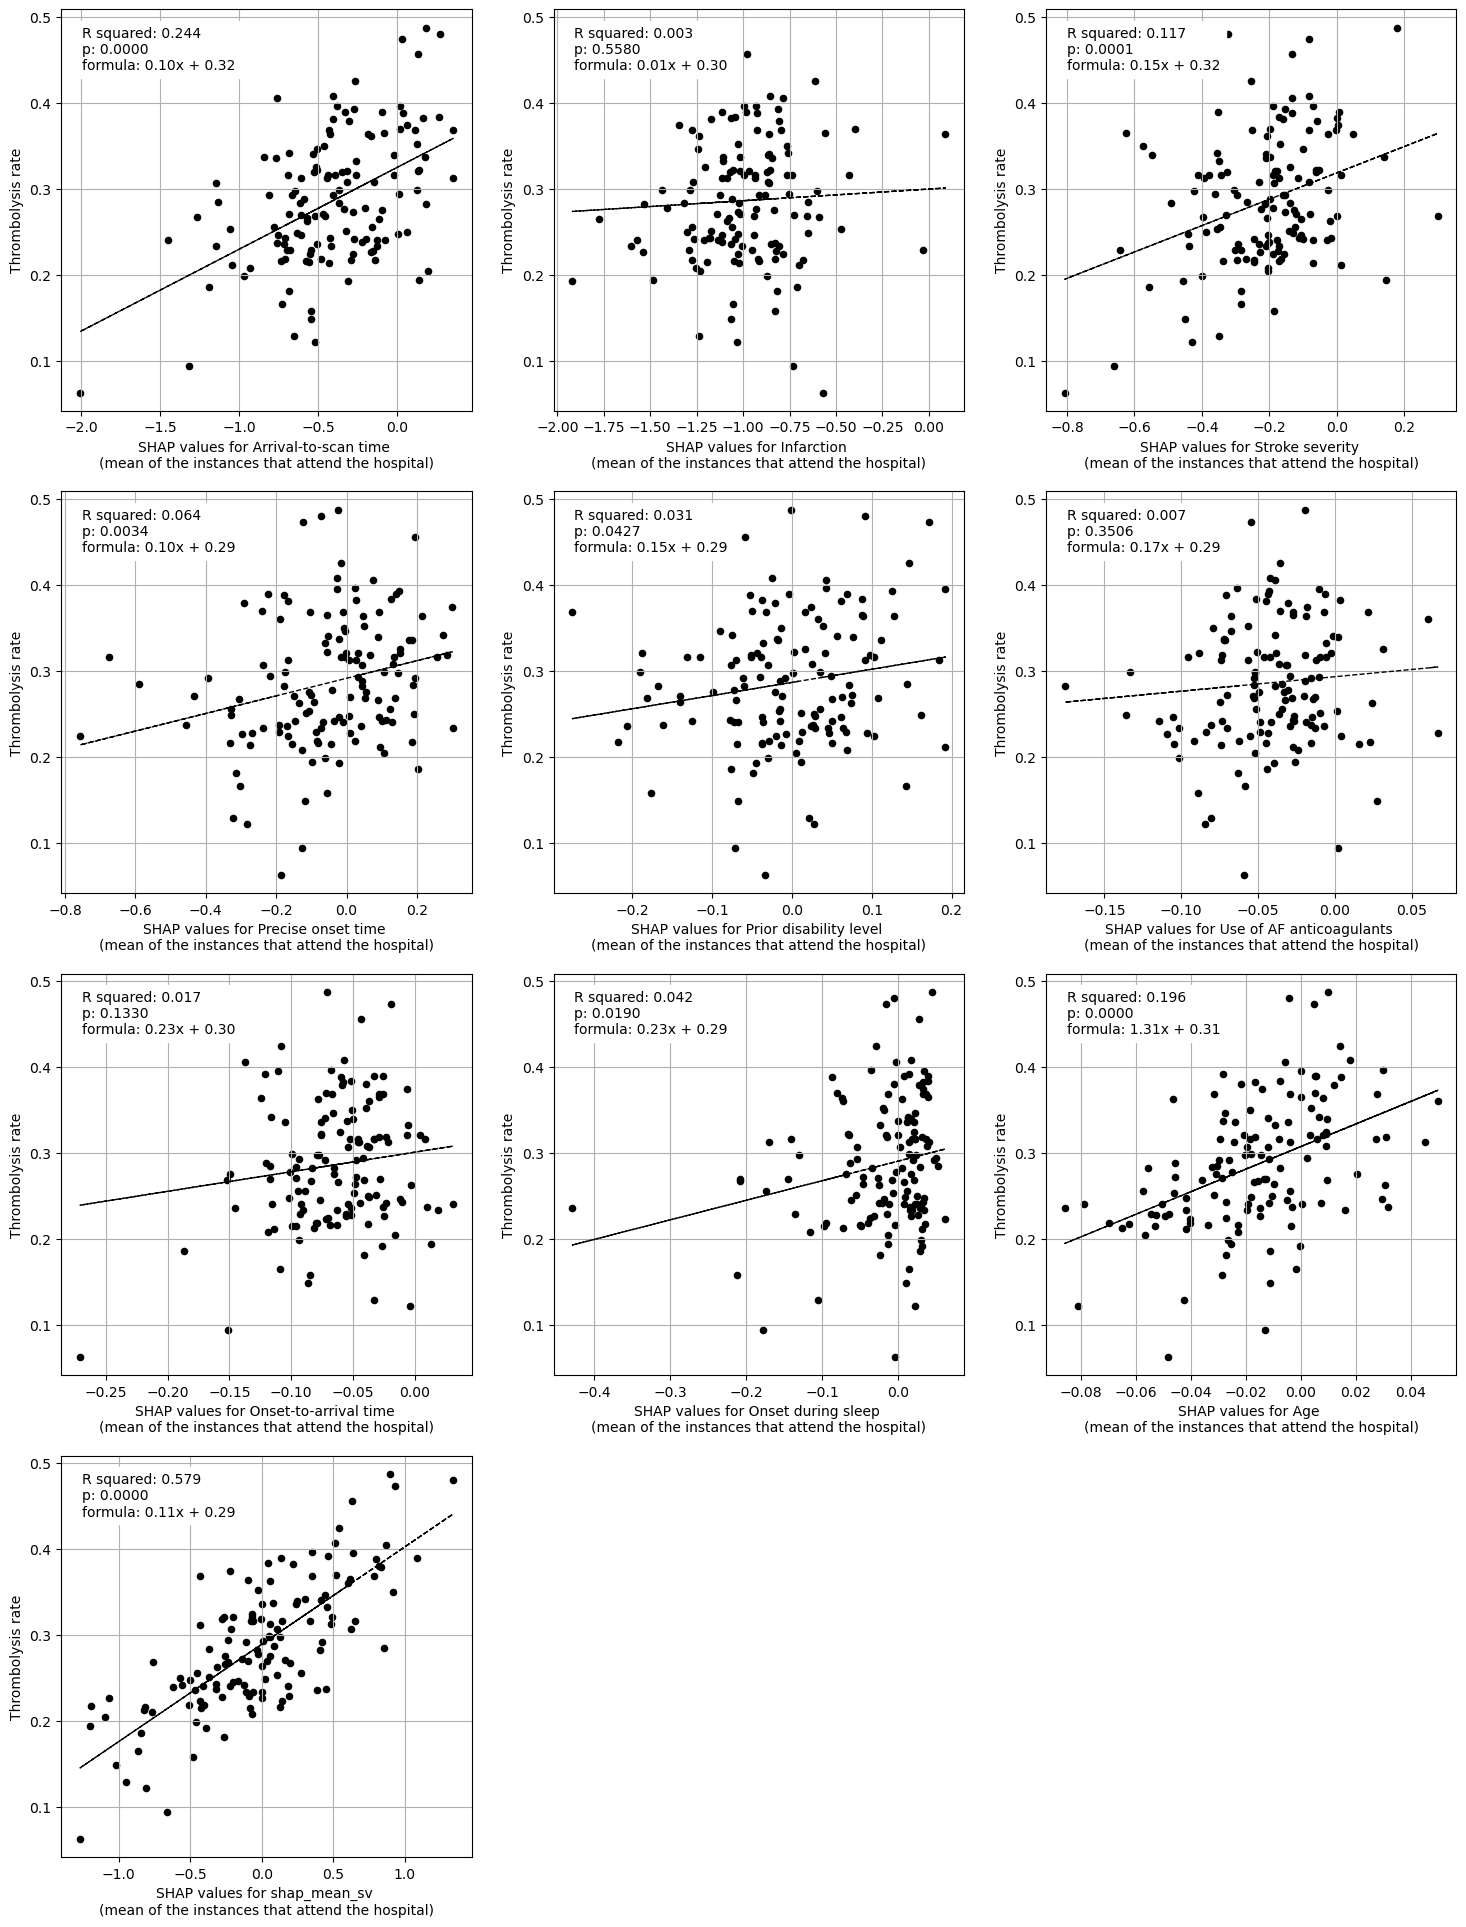

In [24]:
features_to_plot = ['Arrival-to-scan time','Infarction','Stroke severity',
                        'Precise onset time','Prior disability level',
                        'Use of AF anticoagulants','Onset-to-arrival time',
                        'Onset during sleep','Age', 'shap_mean_sv']

title = "SHAP values for"
df = df_mean_shap_values_per_hosp

print("Regression between hosptial IVT rate and SHAP value for features "
      "(mean for those instances that attend the hospital)")
print()
plot_regressions(df, features_to_plot, title)
print ()

#### Multiple regression on all features vs IVT rate

Multiple regression between hosptial IVT rate and SHAP value for all features (mean for those instances that attend the hospital)

                             coeff
Arrival-to-scan time      0.066249
Infarction                0.034880
Stroke severity           0.089651
Precise onset time        0.116825
Prior disability level    0.090232
Use of AF anticoagulants  0.129920
Onset-to-arrival time    -0.098246
Onset during sleep        0.068122
Age                       0.178001
shap_mean_sv              0.109368



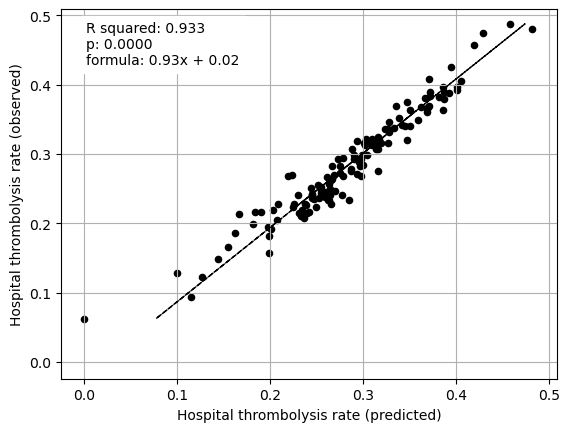

In [25]:
print("Multiple regression between hosptial IVT rate and SHAP value for all "
      "features (mean for those instances that attend the hospital)")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
plt.show()

#### Multiple regression on features (excluding attended hosptial) vs IVT rate

Multiple regression between hosptial IVT rate and SHAP value for features (mean for those instances that attend the hospital), excluding attended hospital SHAP

                             coeff
Arrival-to-scan time      0.079886
Infarction                0.063246
Stroke severity           0.111067
Precise onset time        0.046224
Prior disability level    0.050308
Use of AF anticoagulants  0.036244
Onset-to-arrival time    -0.088946
Onset during sleep        0.074848
Age                       0.785148



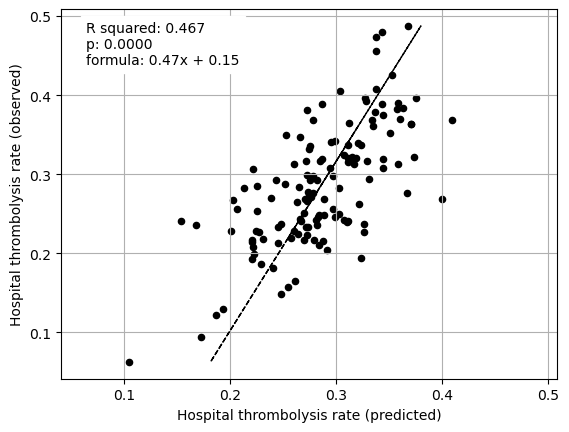

In [26]:
features_to_plot = ['Arrival-to-scan time','Infarction','Stroke severity',
                      'Precise onset time','Prior disability level',
                      'Use of AF anticoagulants','Onset-to-arrival time',
                      'Onset during sleep','Age']

print("Multiple regression between hosptial IVT rate and SHAP value for features "
      "(mean for those instances that attend the hospital), excluding "
      "attended hospital SHAP")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
plt.show()

#### Multiple regression on just patient characteristics vs IVT rate

Multiple regression between hosptial IVT rate and SHAP value for just patient features (mean for those instances that attend the hospital)

                             coeff
Infarction                0.041041
Stroke severity           0.136061
Precise onset time        0.060148
Prior disability level    0.047838
Use of AF anticoagulants -0.058462
Onset-to-arrival time     0.071181
Onset during sleep        0.111865
Age                       1.062042



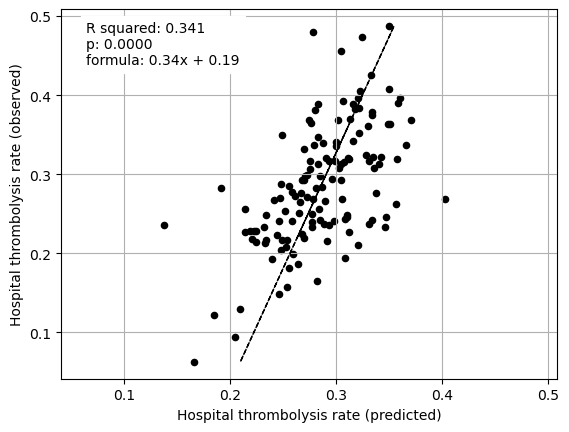

In [27]:
features_to_plot = ['Infarction','Stroke severity',
                            'Precise onset time','Prior disability level',
                            'Use of AF anticoagulants','Onset-to-arrival time',
                            'Onset during sleep','Age']

print("Multiple regression between hosptial IVT rate and SHAP value for just "
      "patient features (mean for those instances that attend the hospital)")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
plt.show()

#### Multiple regression on just hospital processes vs IVT rate

Multiple regression between hosptial IVT rate and SHAP value for features (mean for those instances that attend the hospital)

                         coeff
Arrival-to-scan time  0.079994
shap_mean_sv          0.106429



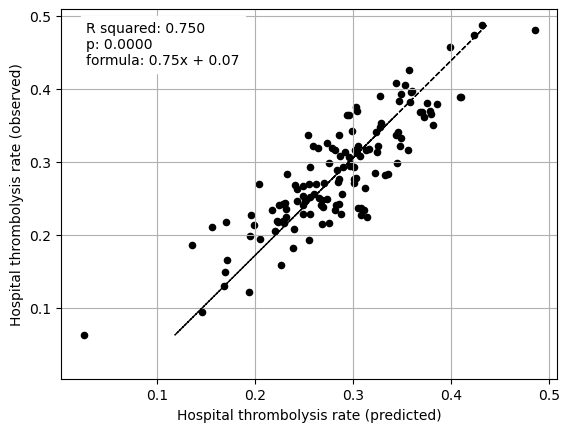

In [28]:
features_to_plot = ['Arrival-to-scan time','shap_mean_sv']

print("Multiple regression between hosptial IVT rate and SHAP value for features "
      "(mean for those instances that attend the hospital)")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
plt.show()

Is there a correlation between IVT rate and proportion ischemeic?

In [29]:
# Calculate infarction rate per hosptial
df_hosp_isch_rate = data.groupby(by=["Stroke team"]).mean()["Infarction"]
df_hosp_isch_ivt_rate = pd.concat([df_hosp_isch_rate, df_hosp_ivt_rate], axis=1)
df_hosp_isch_ivt_rate = df_hosp_isch_ivt_rate.rename(
                                columns={"Infarction":"Proportion infarction"})
df_hosp_isch_ivt_rate

,Proportion infarction,Thrombolysis
Stroke team,,
AGNOF1041H,0.846154,0.352468
AKCGO9726K,0.916667,0.369748
AOBTM3098N,0.866667,0.218803
APXEE8191H,0.783972,0.226481
ATDID5461S,0.817308,0.240385
...,...,...
YPKYH1768F,0.854890,0.246057
YQMZV4284N,0.859574,0.236170
ZBVSO0975W,0.821759,0.250000


Regression between hosptial IVT rate and proportion of patients with infarction



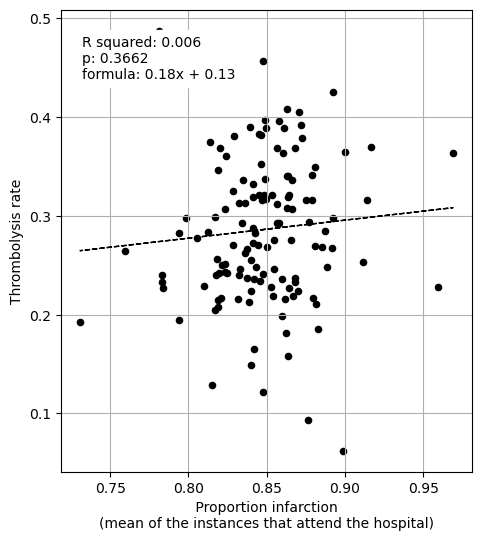

()

In [30]:
features_to_plot = ['Proportion infarction']

print("Regression between hosptial IVT rate and proportion of patients with "
      "infarction")
print()
plot_regressions(df_hosp_isch_ivt_rate, features_to_plot, "")

## Repeat using SHAP main effect

### Get SHAP interaction values
A SHAP interaction value is returned for each pair of features (including with itself, which is known as the main effect), for each instance. The SHAP value for a feature is the sum of it's pair-wise feature interactions.

We used the TreeExplainer (from the shap library: https://shap.readthedocs.io/en/latest/index.html) to calculate the SHAP interaction values (notebook 03c).

'Raw' SHAP interaction values from XGBoost model are log odds ratios.

Load from pickle (from notebook 03c).

In [31]:
%%time
filename = f'./output/03c_{model_text}_shap_interactions.p'

# Load SHAP interaction
with open(filename, 'rb') as filehandler:
    shap_interactions = pickle.load(filehandler)

CPU times: user 4.87 ms, sys: 2.71 s, total: 2.72 s
Wall time: 2.72 s


In [32]:
shap_interactions.shape

(88792, 141, 141)

Get main effect for each feature for each patient

In [33]:
# Initialise list
shap_main_effects = []

# For each patient
for i in range(shap_interactions.shape[0]):
# Get the main effect value for each of the features
    main_effects = np.diagonal(shap_interactions[i])
    shap_main_effects.append(main_effects)

# Put main effects in dataframe with features as column title
df_hosp_shap_main_effects = pd.DataFrame(shap_main_effects, 
                                         columns=feature_names_ohe)

# Only keep the hospital one-hot encoded feature for the attended hospital

# Initialise list
shap_of_team_attended = []

# For each patient
for i in range(shap_interactions.shape[0]):
    shap_of_team_attended.append(
        df_hosp_shap_main_effects[f"team_{data['Stroke team'].loc[i]}"].loc[i])

# Store the SHAP values for the hospital attended
df_hosp_shap_main_effects["Stroke team"] = shap_of_team_attended

# remove thrombolysis
feature_names_keep = feature_names[0:-1]
df_hosp_shap_main_effects = df_hosp_shap_main_effects[feature_names_keep]

In [34]:
df_hosp_shap_main_effects.head()

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age
0,0.676277,0.338386,0.862582,0.430773,0.322120,-0.187852,0.135322,-0.441546,0.042960,0.231744
1,0.447184,0.339734,0.297246,0.434184,0.331810,-0.580359,0.138708,0.165874,0.048222,0.235642
2,-2.979032,0.321163,-1.694299,0.420702,0.379625,-1.192582,0.148083,0.001259,0.039560,0.125615
3,0.336959,-8.517138,0.747195,0.435908,0.358994,0.977001,0.161105,0.071381,0.043983,0.042129
4,0.847006,0.340107,0.851986,0.437559,0.336050,0.070702,0.143654,0.160698,0.044551,0.053406


In [35]:
# Create dataframe with hospital as index, column per feature, containing
# mean SHAP main effect for feature for patients that attend that hospital

# Initialise list
mean_shap_main_effect_hosp = []

# For each hosptial
for h in unique_stroketeams_list:
#    calcualte mean shap main effect for the patients that attend hospital
    mask = data["Stroke team"] == h
    mean_shap_main_effect_hosp.append(np.mean(df_hosp_shap_main_effects[mask],axis=0))

# Create DataFrame
df_mean_shap_main_effect_per_hosp = pd.DataFrame(data=mean_shap_main_effect_hosp, 
                                                   index=unique_stroketeams_list,
                                                   columns=feature_names_keep)

In [36]:
df_mean_shap_main_effect_per_hosp

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age
AOBTM3098N,-0.781391,-0.837082,-0.149835,0.049635,0.012531,-0.390772,-0.062263,-0.046660,-0.067334,-0.044815
QQUVD2066Z,0.134090,-1.002392,-0.125507,0.202943,-0.073116,0.625144,-0.089202,-0.036222,0.032351,-0.044030
JHDQL1362V,-0.395021,-1.125387,-0.302660,0.041979,-0.042290,0.040766,-0.012047,-0.075419,-0.042522,-0.012828
BXXZS5063A,-0.710763,-0.646758,-0.114046,-0.364860,0.151970,-0.039883,-0.155382,-0.020414,0.011284,-0.020753
IUMNL9626U,-1.202068,-0.696896,-0.542578,0.238191,-0.152271,-0.814282,-0.035247,-0.065188,0.035691,-0.023318
...,...,...,...,...,...,...,...,...,...,...
WSFVN0229E,-1.081844,-0.438762,-0.408264,-0.137084,-0.028605,0.119907,-0.001400,-0.026640,0.005162,-0.036282
PSNKC7508G,-0.531692,-1.067373,-0.089513,0.069251,-0.050202,0.000200,-0.076808,-0.007752,-0.006380,-0.018600
EQPWM6065O,-0.568333,-1.142110,-0.129391,-0.191133,-0.076851,0.552636,-0.057563,-0.027554,-0.118624,0.000485
TXYJJ1019H,-0.303832,-0.943076,-0.200153,-0.123385,-0.105447,0.084655,-0.044026,-0.050865,0.021769,-0.032892


Add thrombolysis rate

In [37]:
df_mean_shap_main_effect_per_hosp = (
                    df_mean_shap_main_effect_per_hosp.join(df_hosp_ivt_rate))
df_mean_shap_main_effect_per_hosp

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,Thrombolysis
AOBTM3098N,-0.781391,-0.837082,-0.149835,0.049635,0.012531,-0.390772,-0.062263,-0.046660,-0.067334,-0.044815,0.218803
QQUVD2066Z,0.134090,-1.002392,-0.125507,0.202943,-0.073116,0.625144,-0.089202,-0.036222,0.032351,-0.044030,0.456376
JHDQL1362V,-0.395021,-1.125387,-0.302660,0.041979,-0.042290,0.040766,-0.012047,-0.075419,-0.042522,-0.012828,0.292797
BXXZS5063A,-0.710763,-0.646758,-0.114046,-0.364860,0.151970,-0.039883,-0.155382,-0.020414,0.011284,-0.020753,0.248529
IUMNL9626U,-1.202068,-0.696896,-0.542578,0.238191,-0.152271,-0.814282,-0.035247,-0.065188,0.035691,-0.023318,0.185751
...,...,...,...,...,...,...,...,...,...,...,...
WSFVN0229E,-1.081844,-0.438762,-0.408264,-0.137084,-0.028605,0.119907,-0.001400,-0.026640,0.005162,-0.036282,0.252941
PSNKC7508G,-0.531692,-1.067373,-0.089513,0.069251,-0.050202,0.000200,-0.076808,-0.007752,-0.006380,-0.018600,0.319038
EQPWM6065O,-0.568333,-1.142110,-0.129391,-0.191133,-0.076851,0.552636,-0.057563,-0.027554,-0.118624,0.000485,0.313088
TXYJJ1019H,-0.303832,-0.943076,-0.200153,-0.123385,-0.105447,0.084655,-0.044026,-0.050865,0.021769,-0.032892,0.275946


#### Linear regression of each feature vs. hosptial thrombolysis rate

Regression between hosptial IVT rate and SHAP main effect for features (mean for those instances that attend the hospital)



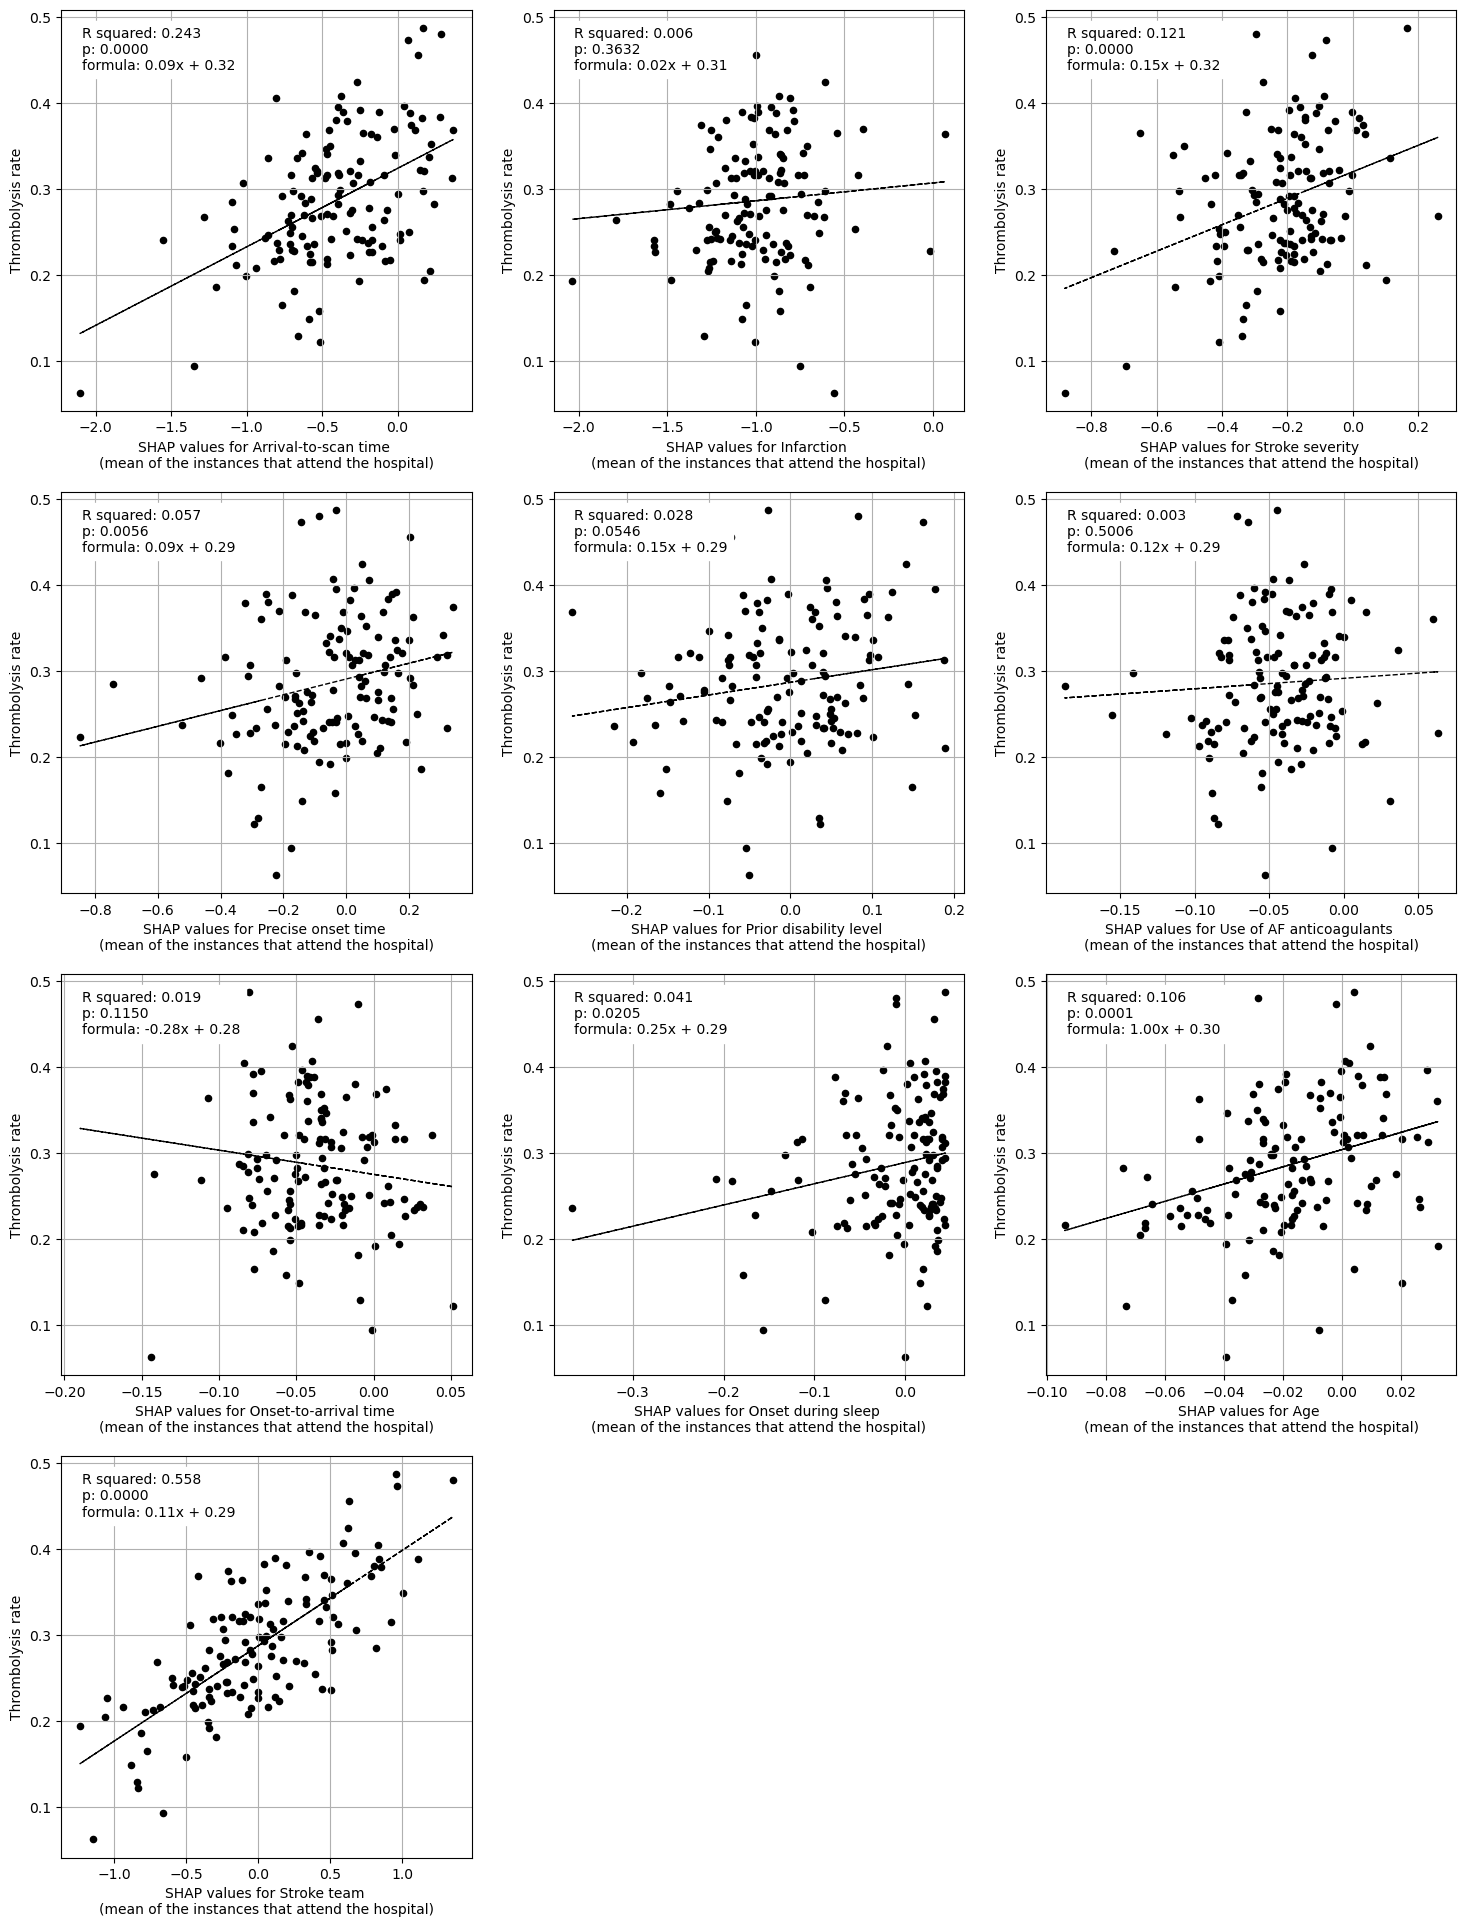

()

In [38]:
features_to_plot = ['Arrival-to-scan time','Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age', 'Stroke team']

title = "SHAP values for"
df = df_mean_shap_main_effect_per_hosp

print("Regression between hosptial IVT rate and SHAP main effect for features "
      "(mean for those instances that attend the hospital)")
print()
plot_regressions(df, features_to_plot, title)

#### Multiple regression on all features vs IVT rate

Multiple regression between hosptial IVT rate and SHAP main effect for all features (mean for those instances that attend the hospital)

                             coeff
Arrival-to-scan time      0.057707
Infarction                0.039323
Stroke severity           0.096127
Precise onset time        0.120060
Prior disability level    0.114161
Use of AF anticoagulants  0.125367
Onset-to-arrival time    -0.038941
Onset during sleep        0.119999
Age                       0.063427
Stroke team               0.113671



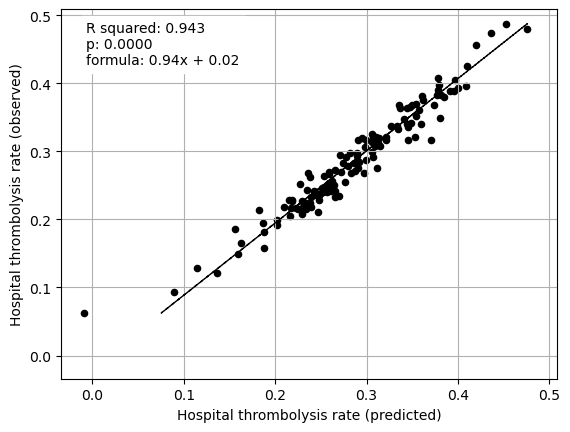

In [39]:
print("Multiple regression between hosptial IVT rate and SHAP main effect for "
      "all features (mean for those instances that attend the hospital)")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
plt.show()

#### Multiple regression on features (excluding attended hosptial) vs IVT rate

Multiple regression between hosptial IVT rate and SHAP main effect for features (mean for those instances that attend the hospital), excluding attended hospital SHAP main effect

                             coeff
Arrival-to-scan time      0.077741
Infarction                0.066426
Stroke severity           0.106478
Precise onset time        0.038122
Prior disability level    0.038869
Use of AF anticoagulants  0.078658
Onset-to-arrival time    -0.277673
Onset during sleep        0.139637
Age                       0.667224



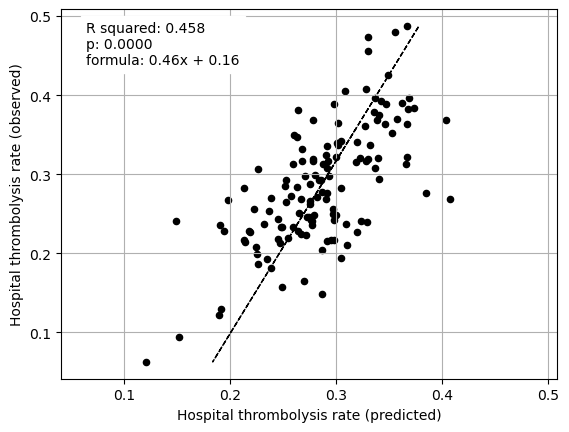

In [40]:
features_to_plot = ['Arrival-to-scan time','Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

print("Multiple regression between hosptial IVT rate and SHAP main effect for "
      "features (mean for those instances that attend the hospital), excluding "
      "attended hospital SHAP main effect")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
plt.show()

#### Multiple regression on just patient characteristics vs IVT rate

Multiple regression between hosptial IVT rate and SHAP main effect for just patient features (mean for those instances that attend the hospital)

                             coeff
Infarction                0.044203
Stroke severity           0.161030
Precise onset time        0.052356
Prior disability level    0.041763
Use of AF anticoagulants  0.004634
Onset-to-arrival time    -0.332927
Onset during sleep        0.216029
Age                       0.793500



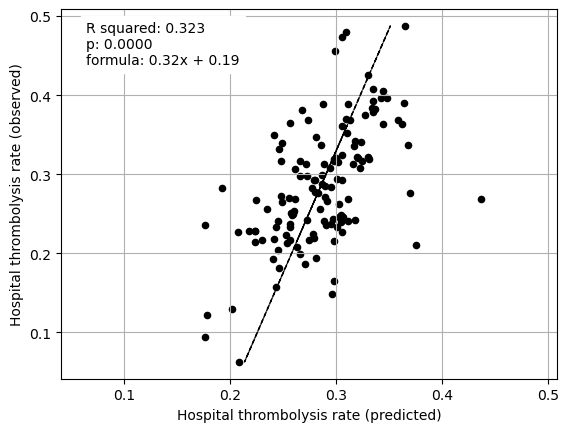

In [41]:
features_to_plot = ['Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

print("Multiple regression between hosptial IVT rate and SHAP main effect for "
      "just patient features (mean for those instances that attend the "
      "hospital)")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
plt.show()

#### Multiple regression on just hospital processes vs IVT rate

Multiple regression between hosptial IVT rate and SHAP main effect for  hospital features (mean for those instances that attend the hospital)

                         coeff
Arrival-to-scan time  0.078443
Stroke team           0.104766



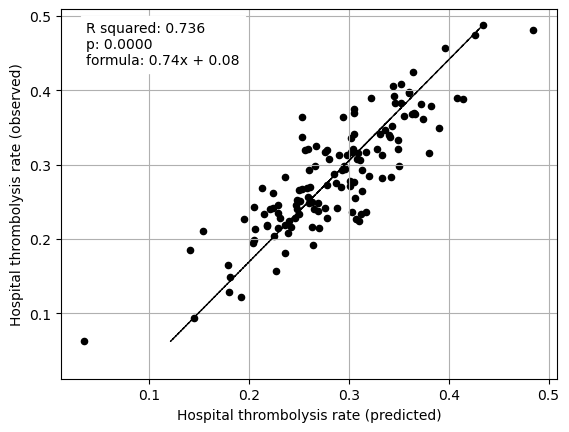

In [42]:
features_to_plot = ['Arrival-to-scan time','Stroke team']

print("Multiple regression between hosptial IVT rate and SHAP main effect for "
      " hospital features (mean for those instances that attend the hospital)")
print()
fit_and_plot_multiple_regression(df, features_to_plot)
plt.show()

We can improve the division of patient features and hosptial features. 

Since we're splitting the features into two groups (hospital features, and patient features) to fit a multiple regression, we can improve what we include in the SHAP value.

So far we have looked at the two extremes: SHAP values (includes all interactions) and main effect (no interactions).

Next let's only include the SHAP interactions for the features that are in the same regression. So only the main effect and the interactions that are with the other features in the multiple regression. Let's call this the *subset* SHAP value.

This will exclude any SHAP interactions that are between the hospital features and patient features - and will remove any leakage of patient information into hospital SHAP, and hospital information into patient SHAP.

Calculate subset SHAP values and fit a multiple regression on these in notebook 03f_xgb_subset_shap_value_regressions_on_hospital_ivt_rate.ipynb.